In [1]:
from itertools import combinations
import re
import os
from tqdm import tqdm
import pandas as pd
import xmltodict
import networkx as nx
import pickle
import collections
import matplotlib.pyplot as plt
from unidecode import unidecode
import altair as alt

tqdm.pandas()
from collections import Counter
import string

# from genderize import Genderize
# genderize = Genderize(
#     user_agent='GenderizeDocs/0.0',
#     api_key='c363eacf807f4af4992b358200ebc15c',
#     timeout=30.0)

with open("dict_genders.pickle", "rb") as handle:
    dict_genders = pickle.load(handle)

pd.set_option("display.max_columns", None)

In [2]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora
import pyLDAvis.gensim_models
import pyLDAvis

stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saurabh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def extract_authors(dc):
    if type(dc) == list:
        result = [
            unidecode(i.get("#text").title().strip())
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") != "institution"
        ]
        return [x for x in result if x != "And Others"]
    elif dc.get("#text") is not None and dc.get("@scheme") != "institution":
        return [unidecode(dc.get("#text").title().strip())]


def clean_name(name):
    if ", " in name:
        lst = name.split(", ")
        lst = [item.split(" ")[0] for item in lst]
        return lst[1] + " " + lst[0]
    elif "," in name:
        lst = name.split(",")
        lst = [item.split(" ")[0] for item in lst]
        return lst[1] + " " + lst[0]
    else:
        return name


def get_first_names(author_list):

    if len(author_list) > 0:
        names = []
        for x in author_list:
            words_in_name = len(x.split())

            if words_in_name > 0:
                first = re.sub(r"[^\w\s]", "", x.split()[0])
            if words_in_name > 1:
                second = re.sub(r"[^\w\s]", "", x.split()[1])
            if words_in_name > 2:
                third = re.sub(r"[^\w\s]", "", x.split()[2])
            if words_in_name > 3:
                fourth = re.sub(r"[^\w\s]", "", x.split()[3])

            if words_in_name > 0 and len(first) > 1:
                names.append(first)
            elif words_in_name > 1 and len(second) > 1:
                names.append(second)
            elif words_in_name > 2 and len(third) > 1:
                names.append(third)
            elif words_in_name > 3 and len(fourth) > 1:
                names.append(fourth)
            else:
                names.append(x)

        return names
    else:
        return None


def name_to_gender(first_name_list):
    if first_name_list and len(first_name_list) > 0:
        return [dict_genders[name] for name in first_name_list]
    else:
        return None


def get_edges(auth_list):
    return list(combinations(auth_list, 2))


def extract_ids(dc):
    if type(dc) == list:
        return [
            i.get("#text").upper().strip()
            for i in dc
            if i.get("#text") is not None and i.get("@scheme") == "eric_accno"
        ][0]
    elif dc.get("#text") is not None and dc.get("@scheme") == "eric_accno":
        return dc.get("#text").upper().strip()


def extract_subject(dc):
    result = []
    for item in dc:
        if type(item) == collections.OrderedDict:
            result.append(unidecode(item.get("#text").title().strip()))
        elif type(item) == str:
            result.append(unidecode(item.title().strip()))
        else:
            result.append(unidecode(item.title().strip()))
    return result


def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

In [4]:
df_all = []

for year in tqdm(range(1965, 2021)):
    file_name = "data/eric" + str(year)
    with open(file_name + ".xml", encoding="utf-8") as fd:
        dict = xmltodict.parse(fd.read())
    recs = [rec["metadata"] for rec in dict["records"]["record"]]
    df = pd.DataFrame(recs)

    df = df[df["dc:type"].notna()]
    df = df[df["eric:peer_reviewed"].notna()]
    df["type"] = ["".join(map(str, l)).lower() for l in df["dc:type"]]
    df = df.loc[df["eric:peer_reviewed"] == "T"]
    # df = df[['ids', 'authors', 'edges', 'dc:type', 'dc:subject', 'eric:keywords', 'eric:keywords_geo', 'dc:title', 'eric:pageCount', 'dc:date', 'eric:dateAdded']]
    df_all.append(df)

df_all = pd.concat(df_all)

100%|███████████████████████████████████████████| 56/56 [07:18<00:00,  7.83s/it]


In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925677 entries, 17594 to 44897
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   dcterms:accessRights       925677 non-null  object
 1   dc:subject                 925673 non-null  object
 2   dc:creator                 925677 non-null  object
 3   dc:type                    925677 non-null  object
 4   eric:keywords              405305 non-null  object
 5   eric:keywords_geo          308256 non-null  object
 6   eric:issn                  752395 non-null  object
 7   dc:language                922586 non-null  object
 8   dcterms:educationLevel     336418 non-null  object
 9   dc:description             925180 non-null  object
 10  dc:identifier              925677 non-null  object
 11  dc:title                   925677 non-null  object
 12  dc:source                  925676 non-null  object
 13  eric:citation              918828 non-nul

In [6]:
df_all["eric:dateAdded"] = pd.to_numeric(df_all["eric:dateAdded"])

In [8]:
df_all = df_all.loc[(df_all["type"].str.contains("journal"))]

# get author names
df_all["authors"] = df_all.progress_apply(lambda row: extract_authors(row["dc:creator"]), axis=1)
df_all = df_all[df_all["authors"].notna()]  # remove nan authors
df_all["authors"] = df_all.progress_apply(
    lambda row: [clean_name(item) for item in row["authors"]], axis=1
)

# get edges
df_all["n_authors"] = df_all.progress_apply(lambda row: len(row["authors"]), axis=1)
df_all["edges"] = df_all.progress_apply(
    lambda row: get_edges(sorted(row["authors"])), axis=1
)
# df_all["ids"] = df_all.progress_apply(lambda row: extract_ids(row["dc:identifier"]), axis=1)

# get subjects
df_all = df_all[df_all["dc:subject"].notna()]
df_all["subjects"] = df_all.progress_apply(
    lambda row: extract_subject(row["dc:subject"]), axis=1
)
df_all["subjects"] = df_all["subjects"].map(lambda x: list(map(str.lower, x)))
# df_all.loc[:, "subject_top"] = df_all.subjects.map(lambda x: x[0])

# get author first name and then use it to predict gender
df_all["author_first_names"] = df_all.progress_apply(
    lambda row: get_first_names(row["authors"]), axis=1
)
df_all["author_genders"] = df_all.progress_apply(
    lambda row: name_to_gender(row["author_first_names"]), axis=1
)  # get genders from dict

100%|████████████████████████████████| 913835/913835 [00:11<00:00, 80721.35it/s]
/var/folders/2z/vs42hj694vjcjn3tkdl2tnfw0000gn/T/ipykernel_3928/3674142744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all["authors"] = df_all.progress_apply(lambda row: extract_authors(row["dc:creator"]), axis=1)
100%|████████████████████████████████| 908417/908417 [01:14<00:00, 12193.59it/s]


In [10]:
df_all["subjects_str"] = [",".join(map(str, l)).lower() for l in df_all["subjects"]]
df_all = df_all.loc[(df_all["subjects_str"].str.contains("social network"))]
print(df_all.iloc[27]["subjects_str"])
df_all.info()

delivery systems,gerontology,hotels,inner city,intervention,older adults,program effectiveness,social networks,social support groups,social work
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6466 entries, 18012 to 44782
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   dcterms:accessRights       6466 non-null   object
 1   dc:subject                 6466 non-null   object
 2   dc:creator                 6466 non-null   object
 3   dc:type                    6466 non-null   object
 4   eric:keywords              2699 non-null   object
 5   eric:keywords_geo          3087 non-null   object
 6   eric:issn                  6238 non-null   object
 7   dc:language                6444 non-null   object
 8   dcterms:educationLevel     3755 non-null   object
 9   dc:description             6466 non-null   object
 10  dc:identifier              6466 non-null   object
 11  dc:title               

In [11]:
len(df_all)

6466

In [13]:
df_all["eric:dateAdded"].value_counts().sort_index()

1983     13
1984     27
1985     24
1986     24
1987     32
1988     33
1989     24
1990     23
1991     25
1992     29
1993     20
1994     27
1995     21
1996     28
1997     23
1998     23
1999     44
2000     22
2001     19
2002     29
2003     35
2004     19
2005     62
2006     78
2007    128
2008    300
2009    433
2010    509
2011    424
2012    578
2013    312
2014    669
2015    626
2016    395
2017    380
2018    334
2019    352
2020    322
Name: eric:dateAdded, dtype: int64

## Topic Model

In [14]:
# Remove punctuation
df_all['dc:description'] = df_all['dc:description'].map(lambda x: re.sub('[,\.!?]', '', str(x)))

# Convert to lowercase
df_all['dc:description'] = df_all['dc:description'].map(lambda x: x.lower())

# Print out the first rows of papers
df_all['dc:description'].head()

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
/var/folders/2z/vs42hj694vjcjn3tkdl2tnfw0000gn/T/ipykernel_3928/3754156769.py:2: DeprecationWarning: invalid escape sequence \.
  df_all['dc:description'] = df_all['dc:description'].map(lambda x: re.sub('[,\.!?]', '', str(x)))


18012    describes two successful institutionalized net...
19513    information collected from a sample of 14 wome...
23461    describes a closely knit neighborhood network ...
23463    used data from a national survey of adults to ...
24704    in-depth unstructured interviews and participa...
Name: dc:description, dtype: object

In [15]:
data = df_all["dc:description"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)

In [16]:
len(data_words)

6466

In [19]:
# del df_all
data_words[27]

['describes',
 'experimental',
 'program',
 'focusing',
 'network',
 'approaches',
 'solution',
 'social',
 'work',
 'clients',
 'problems',
 'sample',
 'composed',
 'residents',
 'manhattan',
 'hotel',
 'percent',
 'problems',
 'successfully',
 'resolved',
 'network',
 'interventions',
 'although',
 'problems',
 'amenable',
 'intervention',
 'others',
 'jac']

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [21]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+ str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'results/educ-sn-lda/ldavis_prepared_'+ str(num_topics) +'.html')
# LDAvis_prepared

## Graph Analysis

In [23]:
def generate_graph(df_local):

    node_list1 = df_local["authors"].tolist()
    node_list2 = [x for x in node_list1 if x is not None]  # remove none
    node_list3 = [item for sublist in node_list2 for item in sublist]
    node_list = list(set(node_list3))

    n_papers_per_author = len(node_list3) / len(node_list)

    edge_list1 = df_local["edges"].tolist()
    edge_list2 = [x for x in edge_list1 if x is not None]  # remove none
    edge_list = [item for sublist in edge_list2 for item in sublist]

    G = nx.Graph()
    G.add_nodes_from(node_list)
    G.add_edges_from(edge_list)
    return (G, n_papers_per_author)

### Yearwise graph

In [34]:
# CUMULATIVE NOW
list1 = []

for year in tqdm(range(1965, 2021)):

    df_local = df_all.loc[df_all["eric:dateAdded"] <= year]

    if len(df_local) == 0:
        continue

    result = generate_graph(df_local)
    G = result[0]
    n_authors = len(G)
    n_papers = len(df_local)

    n_authors_per_paper = df_local["n_authors"].mean()
    n_papers_per_author = result[1]

    n_collabs = nx.number_of_edges(G)
    n_isolates = nx.number_of_isolates(G)
    mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())

    G_largest_comp = G.subgraph(
        sorted(nx.connected_components(G), key=len, reverse=True)[0]
    )
    largest_component = len(G_largest_comp) / len(G)

    deg_assort = nx.degree_assortativity_coefficient(G)
    avg_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)

    list1.append(
        (
            year,
            n_authors,
            n_papers,
            n_authors_per_paper,
            n_papers_per_author,
            n_collabs,
            n_isolates,
            mean_collabs,
            largest_component,
            deg_assort,
            avg_clustering,
            transitivity,
        )
    )

df_summary = pd.DataFrame(
    list1,
    columns=[
        "year",
        "n_authors",
        "n_papers",
        "n_authors_per_paper",
        "n_papers_per_author",
        "n_collabs",
        "n_isolates",
        "mean_collabs",
        "largest_component",
        "deg_assort",
        "avg_clustering",
        "transitivity",
    ],
)
df_summary

  0%|                                                    | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████| 56/56 [00:02<00:00, 19.76it/s]


,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,1983,17,13,1.307692,1.000000,4,9,0.470588,0.117647,NaN,0.000000,0.000000
1,1984,52,40,1.325000,1.019231,13,26,0.500000,0.038462,NaN,0.000000,0.000000
2,1985,84,64,1.375000,1.047619,24,36,0.571429,0.023810,NaN,0.000000,0.000000
3,1986,117,88,1.386364,1.042735,34,49,0.581197,0.017094,NaN,0.000000,0.000000
4,1987,158,120,1.366667,1.037975,44,70,0.556962,0.012658,NaN,0.000000,0.000000
5,1988,199,153,1.392157,1.070352,59,83,0.592965,0.015075,-0.035088,0.000000,0.000000
6,1989,232,177,1.395480,1.064655,69,96,0.594828,0.012931,-0.029851,0.000000,0.000000
7,1990,257,200,1.375000,1.070039,73,113,0.568093,0.011673,-0.028169,0.000000,0.000000
8,1991,285,225,1.364444,1.077193,78,131,0.547368,0.010526,-0.026316,0.000000,0.000000
9,1992,321,254,1.370079,1.084112,88,147,0.548287,0.009346,-0.023256,0.000000,0.000000


In [35]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_papers")

alt.Chart(...)

In [36]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_authors")

alt.Chart(...)

In [37]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_authors_per_paper")

alt.Chart(...)

In [38]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_papers_per_author")

alt.Chart(...)

In [39]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_collabs")

alt.Chart(...)

In [40]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="mean_collabs")

alt.Chart(...)

In [41]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="n_isolates")

alt.Chart(...)

In [42]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="largest_component")

alt.Chart(...)

In [43]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="deg_assort")

alt.Chart(...)

In [44]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="avg_clustering")

alt.Chart(...)

In [45]:
alt.Chart(df_summary).mark_area(
    color="lightblue", interpolate="step-after", line=True
).encode(x="year", y="transitivity")

alt.Chart(...)

### Cumulative Graph

In [24]:
list1 = []

result = generate_graph(df_all)
G = result[0]
n_authors = len(G)
n_papers = len(df_all)

n_authors_per_paper = df_all["n_authors"].mean()
n_papers_per_author = result[1]

n_collabs = nx.number_of_edges(G)
n_isolates = nx.number_of_isolates(G)
mean_collabs = 2 * G.number_of_edges() / float(G.number_of_nodes())

G_largest_comp = G.subgraph(
    sorted(nx.connected_components(G), key=len, reverse=True)[0]
)
largest_component = len(G_largest_comp) / len(G)

deg_assort = nx.degree_assortativity_coefficient(G)
avg_clustering = nx.average_clustering(G)
transitivity = nx.transitivity(G)

list1.append(
    (
        year,
        n_authors,
        n_papers,
        n_authors_per_paper,
        n_papers_per_author,
        n_collabs,
        n_isolates,
        mean_collabs,
        largest_component,
        deg_assort,
        avg_clustering,
        transitivity,
    )
)

df_overall = pd.DataFrame(
    list1,
    columns=[
        "year",
        "n_authors",
        "n_papers",
        "n_authors_per_paper",
        "n_papers_per_author",
        "n_collabs",
        "n_isolates",
        "mean_collabs",
        "largest_component",
        "deg_assort",
        "avg_clustering",
        "transitivity",
    ],
)
df_overall

,year,n_authors,n_papers,n_authors_per_paper,n_papers_per_author,n_collabs,n_isolates,mean_collabs,largest_component,deg_assort,avg_clustering,transitivity
0,2020,12746,6466,2.329415,1.181704,16673,1833,2.616193,0.01828,0.588744,0.57955,0.825046


In [25]:
nx.info(G)

'Graph with 12746 nodes and 16673 edges'

In [50]:
# prop of isolates
nx.number_of_isolates(G)/len(G)

0.1438098226894712

In [26]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]

[('Alan Daly', 41),
 ('Nienke Moolenaar', 41),
 ('Erik Carter', 31),
 ('Thomas Farmer', 28),
 ('G. De', 26),
 ('Jill Locke', 24),
 ('Bart Rienties', 23),
 ('William Penuel', 23),
 ('Philip Rodkin', 21),
 ('Connie Kasari', 21),
 ('Martin Knapp', 21),
 ('Rene Veenstra', 20),
 ('Ashanti Edwards', 19),
 ('Elizabeth Vuong', 19),
 ('Ashley Guillory', 19),
 ('Leticia Vega', 19),
 ('Matthew Brock', 19),
 ('Elizabeth Biggs', 19),
 ('Sonia Flores', 19),
 ('Veronica Segarra', 19)]

In [27]:
# function to plot egonet
def draw_ego(name):
    hub_ego = nx.ego_graph(G, name)
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)
    options = {"node_size": 300, "node_color": "r"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[name], **options)

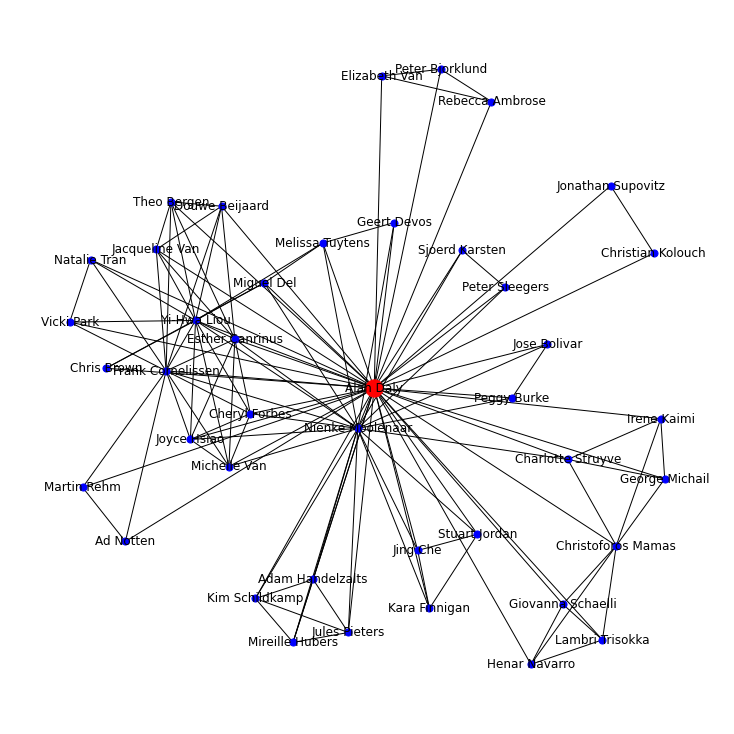

In [33]:
plt.figure(figsize=(10, 10))
draw_ego("Alan Daly")

In [ ]:
# df_summary.to_csv("df_summary.csv", encoding='utf-8', index=False)